In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 80
# BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [10]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)

def get_radnom_normal_indices(dataset, train_and_validation, amount):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, amount, replace=False))
    return dataset.iloc[random_normal_indices, :].sample(frac=1)

def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [29]:
# Read CSV
#dataset = pd.read_csv(DATASET_NAME)
dataset = pd.read_csv("research/creditcard.csv")

assert not dataset.isnull().values.any()
#dataset = dataset.drop(['Time','Amount'],axis=1)
#dataset['Amount'] = StandardScaler().fit_transform(dataset[['Amount']])
dataset = dataset.drop(['Amount'],axis=1)
#dataset['Hour'] = dataset['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
dataset = dataset.drop(['Time'],axis=1)
NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'
print(dataset.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...         V20       V21       V22  \
0  0.098698  0.363787  0.090794  ...    0.251412 -0.018307  0.277838   
1  0.085102 -0.255425 -0.166974  ...   -0.069083 -0.225775 -0.638672   
2  0.247676 -1.514654  0.207643  ...    0.524980  0.247998  0.771679   
3  0.377436 -1.387024 -0.054952  ...   -0.208038 -0.108300  0.005274   
4 -0.270533  0.817739  0.753074  ...    0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.110474  0.066928  0.128539 -0.189115  0.

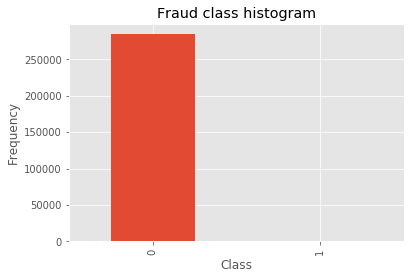

0    284315
1       492
Name: Class, dtype: int64

In [29]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [30]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = split_data(dataset, train_size=0.8)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [31]:
# Create balanced, under sample train and validation dataset 
under_sample_dataset = get_under_sample_dataset(dataset, train_and_validation)


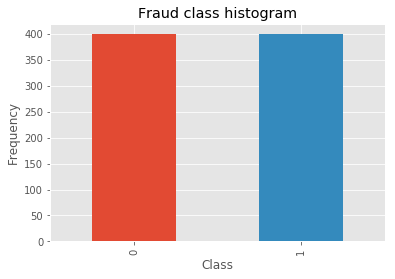

0    399
1    399
Name: Class, dtype: int64

In [32]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [33]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [34]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)

        print("Loss: ", train_loss, " Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))

    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_train, y_train, x_val=None, y_val=None, distinct = 0):
        print(x_train.shape, y_train.shape)
        tr = np.hstack((x_train, y_train))
        tr_f = tr[tr[:, -1] == 1]
        tr_n = tr[tr[:, -1] == 0]
        tr_f_ep = tr_f
        tr_n_ep = tr_n
        tr_score = np.concatenate((tr_f_ep, tr_n[: tr_f.shape[0],:]))
        print("FIT: tyle jest frauds:", tr_f.shape)
        print("FIT: tyle jest normals:", tr_n.shape)
        for i in range(self.epochs):
            if(distinct):
                tr_n = np.roll(tr_n, tr_f.shape[0])
                tr_n_ep = tr_n[: tr_f.shape[0],:]
                tr = np.concatenate((tr_f_ep, tr_n_ep))
                x_tr = tr[:,:-1]
                y_tr = tr[:,-1:]
                
            else:
                x_tr = x_train
                y_tr = y_train
                
            # zeby w kazdej epoce byly inne dobre i te same zle ( w jednej walidacji oczywiscie)
            
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.BIG_DELTAS = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(tr_score[:,:-1], tr_score[:,-1:], x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [35]:
KFOLDS = 5

#Create array with only bad transactions for test&validation
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
fraud_indices = dataset.iloc[fraud_indices, :].sample(frac=1)
fraud_indices = fraud_indices.values

kfold_split_frauds = k_fold_split_data(fraud_indices, KFOLDS)

kfold_split_frauds_lens = [len(x) for x in kfold_split_frauds]
print(kfold_split_frauds)

"""
#Create array with only good transations for test&validation - EPOCHS times larger than fraud_indices
random_normal_test_amount = [(fraud_indices.shape[0]-kfold_split_frauds_lens[x])*EPOCHS for x in range(KFOLDS)]
random_normal_validation_amount = [kfold_split_frauds_lens[x] for x in range(KFOLDS)]
print(random_normal_test_amount)
print(random_normal_validation_amount)
random_normal_total_amount = sum(random_normal_test_amount) + sum(random_normal_validation_amount)
random_normal_indices = get_radnom_normal_indices(dataset, train_and_validation, amount=random_normal_total_amount)
random_normal_indices = random_normal_indices.values
"""
#normal_validation_amount = [kfold_split_frauds_lens[x] for x in range(KFOLDS)]
normal_validation_indices = get_radnom_normal_indices(dataset, train_and_validation, amount=fraud_indices.shape[0])
normal_validation_indices = normal_validation_indices.values
kfold_split_normals = k_fold_split_data(normal_validation_indices, KFOLDS)

"""
# generate indices for all 5 normal validation sets
total_validation_normal_ind = np.random.randint(low = 0, high = random_normal_indices.shape[0],\
                                               size = sum(random_normal_validation_amount))

# [80 numbers, 80 numbers, 79, 79, 79]
total_validation_normal_ind_split = np.array_split(total_validation_normal_ind, 5) 


total_test_normal_ind = np.delete(arr = np.arange(random_normal_total_amount), obj = total_validation_normal_ind, axis = 0)
print("SIZES: ", total_test_normal_ind.shape[0], total_validation_normal_ind.shape[0], total_test_normal_ind.shape[0]+total_validation_normal_ind.shape[0], random_normal_total_amount)

#generate 5 random numbers - indices of 5 normal validation sets (out of 81)
rand_validation_n_i = np.random.randint(low = 0, high = EPOCHS+1, size = 5)
print(rand_validation_n_i)
"""
SEGMENT_SIZE = len(fraud_indices)
print("SEGMENT_SIZE:", SEGMENT_SIZE)

# k-fold validation with k=5
models = []

[array([[-17.46771001,  10.11481572, -24.20214223, ...,   2.09354057,
         -1.42549145,   1.        ],
       [ -5.26805322,   9.06761343, -15.96072813, ...,   1.58469735,
          0.72005587,   1.        ],
       [ -1.46531576,  -1.09337688,  -0.05976785, ...,   0.67552483,
          0.42484935,   1.        ],
       ..., 
       [  0.32959433,   3.7128893 ,  -5.77593511, ...,   0.53050739,
          0.40447405,   1.        ],
       [-19.64185673,  14.70633467, -22.80123769, ...,  -4.12674625,
         -0.64532922,   1.        ],
       [ -1.4108519 ,   2.26827061,  -2.29755365, ...,   0.37359592,
          0.18765725,   1.        ]]), array([[ -5.18787811e+00,   6.96770866e+00,  -1.35109311e+01, ...,
          6.26646781e-01,  -1.69726031e-01,   1.00000000e+00],
       [ -1.29844323e+00,   1.94810045e+00,  -4.50994689e+00, ...,
          6.43094249e-01,   2.01155750e-01,   1.00000000e+00],
       [ -4.51382570e-01,   2.22514650e+00,  -4.95305045e+00, ...,
          4.55179271e

SEGMENT_SIZE:

399

319

(25839, 28)

(25839, 1)

FIT: tyle jest frauds:

(319, 29)

FIT: tyle jest normals:

(25520, 29)

Loss: 

0.491272488531

 Accuracy: 

0.46394984326018807

Loss: 

0.490124843462

 Accuracy: 

0.46394984326018807

Loss: 

0.488285324518

 Accuracy: 

0.46238244514106586

Loss: 

0.485579541974

 Accuracy: 

0.46238244514106586

Loss: 

0.481715454441

 Accuracy: 

0.4608150470219436

Loss: 

0.476209120324

 Accuracy: 

0.4592476489028213

Loss: 

0.468233692869

 Accuracy: 

0.45768025078369906

Loss: 

0.456301347367

 Accuracy: 

0.45454545454545453

Loss: 

0.437529065302

 Accuracy: 

0.45141065830721006

Loss: 

0.405785635649

 Accuracy: 

0.45297805642633227

Loss: 

0.348253695431

 Accuracy: 

0.47962382445141066

Loss: 

0.262746985773

 Accuracy: 

0.6442006269592476

Loss: 

0.197978001176

 Accuracy: 

0.7460815047021944

Loss: 

0.164684283753

 Accuracy: 

0.7789968652037618

Loss: 

0.147024698747

 Accuracy: 

0.780564263322884

Loss: 

0.139049983867

 Accuracy: 

0.7758620689655172

Loss: 

0.137111744871

 Accuracy: 

0.7633228840125392

Loss: 

0.14025959573

 Accuracy: 

0.7539184952978056

Loss: 

0.144374535711

 Accuracy: 

0.7507836990595611

Loss: 

0.149047814644

 Accuracy: 

0.7460815047021944

Loss: 

0.154164739729

 Accuracy: 

0.7335423197492164

Loss: 

0.159577275068

 Accuracy: 

0.7241379310344828

Loss: 

0.165119885264

 Accuracy: 

0.7147335423197492

Loss: 

0.170622491882

 Accuracy: 

0.7100313479623824

Loss: 

0.175931241488

 Accuracy: 

0.6833855799373041

Loss: 

0.180927147386

 Accuracy: 

0.6739811912225705

Loss: 

0.185522102019

 Accuracy: 

0.658307210031348

Loss: 

0.189652464437

 Accuracy: 

0.6520376175548589

Loss: 

0.193276401455

 Accuracy: 

0.6489028213166145

Loss: 

0.196367914702

 Accuracy: 

0.6473354231974922

Loss: 

0.19891083281

 Accuracy: 

0.6442006269592476

Loss: 

0.200904028302

 Accuracy: 

0.6442006269592476

Loss: 

0.202342895846

 Accuracy: 

0.6410658307210031

Loss: 

0.203230800373

 Accuracy: 

0.6426332288401254

Loss: 

0.203572674733

 Accuracy: 

0.64576802507837

Loss: 

0.203369700486

 Accuracy: 

0.6504702194357367

Loss: 

0.202631496833

 Accuracy: 

0.6536050156739812

Loss: 

0.201368748827

 Accuracy: 

0.658307210031348

Loss: 

0.199597775905

 Accuracy: 

0.6630094043887147

Loss: 

0.197330334226

 Accuracy: 

0.664576802507837

Loss: 

0.194587774361

 Accuracy: 

0.670846394984326

Loss: 

0.191384603742

 Accuracy: 

0.6802507836990596

Loss: 

0.187748620543

 Accuracy: 

0.6865203761755486

Loss: 

0.183705269464

 Accuracy: 

0.6990595611285266

Loss: 

0.179284640959

 Accuracy: 

0.7115987460815048

Loss: 

0.17451973004

 Accuracy: 

0.7241379310344828

Loss: 

0.169442147547

 Accuracy: 

0.7460815047021944

Loss: 

0.164080135441

 Accuracy: 

0.7539184952978056

Loss: 

0.158469408408

 Accuracy: 

0.7617554858934169

Loss: 

0.152651378286

 Accuracy: 

0.774294670846395

Loss: 

0.146673516122

 Accuracy: 

0.780564263322884

Loss: 

0.140579862175

 Accuracy: 

0.7978056426332288

Loss: 

0.134417347787

 Accuracy: 

0.8072100313479624

Loss: 

0.128232923763

 Accuracy: 

0.8166144200626959

Loss: 

0.122070777111

 Accuracy: 

0.8322884012539185

Loss: 

0.115973946527

 Accuracy: 

0.8432601880877743

Loss: 

0.109989372547

 Accuracy: 

0.8526645768025078

Loss: 

0.104160571135

 Accuracy: 

0.8636363636363636

Loss: 

0.0985341181714

 Accuracy: 

0.8714733542319749

Loss: 

0.0931556913923

 Accuracy: 

0.8761755485893417

Loss: 

0.0880634377941

 Accuracy: 

0.8855799373040752

Loss: 

0.0832945697473

 Accuracy: 

0.8918495297805643

Loss: 

0.0788825615432

 Accuracy: 

0.8996865203761756

Loss: 

0.0748531236511

 Accuracy: 

0.9075235109717869

Loss: 

0.0712279117934

 Accuracy: 

0.9153605015673981

Loss: 

0.0680144764076

 Accuracy: 

0.9200626959247649

Loss: 

0.0652076708478

 Accuracy: 

0.9200626959247649

Loss: 

0.0627903879025

 Accuracy: 

0.9231974921630094

Loss: 

0.0607359270485

 Accuracy: 

0.9247648902821317

Loss: 

0.0590152418822

 Accuracy: 

0.9247648902821317

Loss: 

0.0575987931708

 Accuracy: 

0.9263322884012539

Loss: 

0.0564580545365

 Accuracy: 

0.9278996865203761

Loss: 

0.0555664153332

 Accuracy: 

0.9294670846394985

Loss: 

0.0548980902428

 Accuracy: 

0.9341692789968652

Loss: 

0.0544292498196

 Accuracy: 

0.9357366771159875

Loss: 

0.0541373376914

 Accuracy: 

0.9357366771159875

Loss: 

0.054000797584

 Accuracy: 

0.9341692789968652

Loss: 

0.0539995255416

 Accuracy: 

0.9341692789968652

Loss: 

0.0541148058815

 Accuracy: 

0.9373040752351097

Loss: 

0.0543292824814

 Accuracy: 

0.9357366771159875


Validation dataset evaluation:

Loss: 

0.0446473262443

Accuracy: 

0.9375

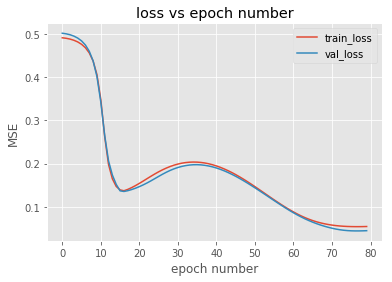

319

(25839, 28)

(25839, 1)

FIT: tyle jest frauds:

(319, 29)

FIT: tyle jest normals:

(25520, 29)

Loss: 

0.205055153525

 Accuracy: 

0.6880877742946708

Loss: 

0.200413294324

 Accuracy: 

0.6880877742946708

Loss: 

0.19451169511

 Accuracy: 

0.6974921630094044

Loss: 

0.18823382188

 Accuracy: 

0.7100313479623824

Loss: 

0.182308719803

 Accuracy: 

0.7178683385579937

Loss: 

0.177181016635

 Accuracy: 

0.725705329153605

Loss: 

0.173013775426

 Accuracy: 

0.7288401253918495

Loss: 

0.169752948657

 Accuracy: 

0.7225705329153606

Loss: 

0.167225579803

 Accuracy: 

0.7163009404388715

Loss: 

0.165218539117

 Accuracy: 

0.719435736677116

Loss: 

0.163531127899

 Accuracy: 

0.7210031347962382

Loss: 

0.161999033513

 Accuracy: 

0.7225705329153606

Loss: 

0.160497657058

 Accuracy: 

0.731974921630094

Loss: 

0.15893931189

 Accuracy: 

0.7304075235109718

Loss: 

0.157262129245

 Accuracy: 

0.7398119122257053

Loss: 

0.155423335493

 Accuracy: 

0.7429467084639498

Loss: 

0.153394160209

 Accuracy: 

0.7429467084639498

Loss: 

0.151160831783

 Accuracy: 

0.7523510971786834

Loss: 

0.148711907507

 Accuracy: 

0.7586206896551724

Loss: 

0.146049094297

 Accuracy: 

0.7633228840125392

Loss: 

0.143176704597

 Accuracy: 

0.7758620689655172

Loss: 

0.140109296552

 Accuracy: 

0.7836990595611285

Loss: 

0.136861894583

 Accuracy: 

0.7931034482758621

Loss: 

0.133456032149

 Accuracy: 

0.8087774294670846

Loss: 

0.129915967181

 Accuracy: 

0.8197492163009404

Loss: 

0.126274469331

 Accuracy: 

0.829153605015674

Loss: 

0.122565863431

 Accuracy: 

0.8479623824451411

Loss: 

0.118827710596

 Accuracy: 

0.85423197492163

Loss: 

0.115098055688

 Accuracy: 

0.8652037617554859

Loss: 

0.111411164936

 Accuracy: 

0.8761755485893417

Loss: 

0.107799243521

 Accuracy: 

0.8871473354231975

Loss: 

0.104287522508

 Accuracy: 

0.890282131661442

Loss: 

0.100900631698

 Accuracy: 

0.8996865203761756

Loss: 

0.0976563483934

 Accuracy: 

0.9059561128526645

Loss: 

0.0945645192043

 Accuracy: 

0.9043887147335423

Loss: 

0.0916337802856

 Accuracy: 

0.9059561128526645

Loss: 

0.0888688607383

 Accuracy: 

0.9106583072100314

Loss: 

0.0862766055829

 Accuracy: 

0.9090909090909091

Loss: 

0.0838605727811

 Accuracy: 

0.9106583072100314

Loss: 

0.0816223989693

 Accuracy: 

0.9122257053291536

Loss: 

0.0795608729419

 Accuracy: 

0.9122257053291536

Loss: 

0.0776736801284

 Accuracy: 

0.9137931034482759

Loss: 

0.0759559237502

 Accuracy: 

0.9137931034482759

Loss: 

0.0744000492335

 Accuracy: 

0.9153605015673981

Loss: 

0.0729971217003

 Accuracy: 

0.9137931034482759

Loss: 

0.0717366688589

 Accuracy: 

0.9137931034482759

Loss: 

0.0706078644894

 Accuracy: 

0.9153605015673981

Loss: 

0.0695990053799

 Accuracy: 

0.9153605015673981

Loss: 

0.0686993252375

 Accuracy: 

0.9169278996865203

Loss: 

0.0678989339213

 Accuracy: 

0.9184952978056427

Loss: 

0.0671895142408

 Accuracy: 

0.9231974921630094

Loss: 

0.0665637632583

 Accuracy: 

0.9231974921630094

Loss: 

0.0660154000856

 Accuracy: 

0.9231974921630094

Loss: 

0.0655387982945

 Accuracy: 

0.9216300940438872

Loss: 

0.0651287205616

 Accuracy: 

0.9231974921630094

Loss: 

0.064779191764

 Accuracy: 

0.9231974921630094

Loss: 

0.0644838488992

 Accuracy: 

0.9231974921630094

Loss: 

0.0642360458759

 Accuracy: 

0.9247648902821317

Loss: 

0.0640289053736

 Accuracy: 

0.9247648902821317

Loss: 

0.0638556378379

 Accuracy: 

0.9247648902821317

Loss: 

0.0637098138889

 Accuracy: 

0.9247648902821317

Loss: 

0.0635859313451

 Accuracy: 

0.9247648902821317

Loss: 

0.0634790604588

 Accuracy: 

0.9263322884012539

Loss: 

0.0633855414956

 Accuracy: 

0.9263322884012539

Loss: 

0.0633026666146

 Accuracy: 

0.9278996865203761

Loss: 

0.06322762667

 Accuracy: 

0.9278996865203761

Loss: 

0.0631581703625

 Accuracy: 

0.9278996865203761

Loss: 

0.0630921381076

 Accuracy: 

0.9263322884012539

Loss: 

0.0630279236521

 Accuracy: 

0.9263322884012539

Loss: 

0.0629641026485

 Accuracy: 

0.9263322884012539

Loss: 

0.0629004929421

 Accuracy: 

0.9263322884012539

Loss: 

0.0628363536382

 Accuracy: 

0.9263322884012539

Loss: 

0.0627710849265

 Accuracy: 

0.9263322884012539

Loss: 

0.0627042524719

 Accuracy: 

0.9278996865203761

Loss: 

0.0626352905185

 Accuracy: 

0.9278996865203761

Loss: 

0.0625642306853

 Accuracy: 

0.9278996865203761

Loss: 

0.0624914369421

 Accuracy: 

0.9278996865203761

Loss: 

0.062416846068

 Accuracy: 

0.9278996865203761

Loss: 

0.0623404233887

 Accuracy: 

0.9278996865203761

Loss: 

0.0622620573948

 Accuracy: 

0.9278996865203761


Validation dataset evaluation:

Loss: 

0.0349377327737

Accuracy: 

0.95

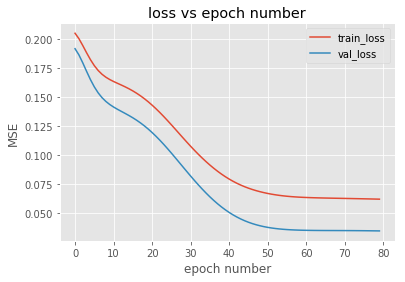

319

(25839, 28)

(25839, 1)

FIT: tyle jest frauds:

(319, 29)

FIT: tyle jest normals:

(25520, 29)

Loss: 

0.241225256676

 Accuracy: 

0.5391849529780565

Loss: 

0.23883887561

 Accuracy: 

0.542319749216301

Loss: 

0.235686365413

 Accuracy: 

0.5454545454545454

Loss: 

0.232103676521

 Accuracy: 

0.5454545454545454

Loss: 

0.228356639182

 Accuracy: 

0.5501567398119123

Loss: 

0.224601877918

 Accuracy: 

0.5532915360501567

Loss: 

0.22089157956

 Accuracy: 

0.5579937304075235

Loss: 

0.217205549307

 Accuracy: 

0.567398119122257

Loss: 

0.213477067238

 Accuracy: 

0.5752351097178683

Loss: 

0.209629313411

 Accuracy: 

0.5799373040752351

Loss: 

0.205588777521

 Accuracy: 

0.5893416927899686

Loss: 

0.201294397512

 Accuracy: 

0.5956112852664577

Loss: 

0.196699589854

 Accuracy: 

0.603448275862069

Loss: 

0.191771236759

 Accuracy: 

0.6159874608150471

Loss: 

0.186497545202

 Accuracy: 

0.6206896551724138

Loss: 

0.180883150672

 Accuracy: 

0.6316614420062696

Loss: 

0.174943546317

 Accuracy: 

0.6426332288401254

Loss: 

0.168722425325

 Accuracy: 

0.6614420062695925

Loss: 

0.162282872638

 Accuracy: 

0.6912225705329154

Loss: 

0.15569050472

 Accuracy: 

0.7178683385579937

Loss: 

0.149024621576

 Accuracy: 

0.7507836990595611

Loss: 

0.142371307486

 Accuracy: 

0.7884012539184952

Loss: 

0.135817076075

 Accuracy: 

0.8103448275862069

Loss: 

0.129443629923

 Accuracy: 

0.8322884012539185

Loss: 

0.123319196089

 Accuracy: 

0.8463949843260188

Loss: 

0.117505442245

 Accuracy: 

0.85423197492163

Loss: 

0.112054096348

 Accuracy: 

0.8652037617554859

Loss: 

0.107003153164

 Accuracy: 

0.8730407523510971

Loss: 

0.102368369195

 Accuracy: 

0.8887147335423198

Loss: 

0.0980938442025

 Accuracy: 

0.9012539184952978

Loss: 

0.0939698923944

 Accuracy: 

0.8981191222570533

Loss: 

0.090063468956

 Accuracy: 

0.9043887147335423

Loss: 

0.0869975502223

 Accuracy: 

0.9106583072100314

Loss: 

0.0845270878799

 Accuracy: 

0.9153605015673981

Loss: 

0.0823865465486

 Accuracy: 

0.9169278996865203

Loss: 

0.0804920737377

 Accuracy: 

0.9075235109717869

Loss: 

0.0787881690539

 Accuracy: 

0.9075235109717869

Loss: 

0.0772296616563

 Accuracy: 

0.9106583072100314

Loss: 

0.0757799187129

 Accuracy: 

0.9106583072100314

Loss: 

0.0744120471089

 Accuracy: 

0.9106583072100314

Loss: 

0.073106311089

 Accuracy: 

0.9106583072100314

Loss: 

0.0718547330325

 Accuracy: 

0.9169278996865203

Loss: 

0.0706615932036

 Accuracy: 

0.9169278996865203

Loss: 

0.0695404700166

 Accuracy: 

0.9169278996865203

Loss: 

0.0685084031521

 Accuracy: 

0.9169278996865203

Loss: 

0.0675792149857

 Accuracy: 

0.9169278996865203

Loss: 

0.0667536516046

 Accuracy: 

0.9184952978056427

Loss: 

0.0660209298504

 Accuracy: 

0.9169278996865203

Loss: 

0.0653637550679

 Accuracy: 

0.9169278996865203

Loss: 

0.0647622091834

 Accuracy: 

0.9169278996865203

Loss: 

0.0642000804815

 Accuracy: 

0.9169278996865203

Loss: 

0.0636647484094

 Accuracy: 

0.9169278996865203

Loss: 

0.0631467716887

 Accuracy: 

0.9184952978056427

Loss: 

0.0626404887506

 Accuracy: 

0.9184952978056427

Loss: 

0.0621413034911

 Accuracy: 

0.9184952978056427

Loss: 

0.0616453187165

 Accuracy: 

0.9184952978056427

Loss: 

0.06114956898

 Accuracy: 

0.9184952978056427

Loss: 

0.0606519994721

 Accuracy: 

0.9184952978056427

Loss: 

0.0601507231785

 Accuracy: 

0.9184952978056427

Loss: 

0.0596441389647

 Accuracy: 

0.9184952978056427

Loss: 

0.0591312230179

 Accuracy: 

0.9184952978056427

Loss: 

0.0586103293006

 Accuracy: 

0.9184952978056427

Loss: 

0.0580801811246

 Accuracy: 

0.9184952978056427

Loss: 

0.0575404909484

 Accuracy: 

0.9184952978056427

Loss: 

0.0569909600054

 Accuracy: 

0.9184952978056427

Loss: 

0.056431559893

 Accuracy: 

0.9184952978056427

Loss: 

0.0558624215022

 Accuracy: 

0.9200626959247649

Loss: 

0.0552839856976

 Accuracy: 

0.9216300940438872

Loss: 

0.054696374348

 Accuracy: 

0.9231974921630094

Loss: 

0.0541008738128

 Accuracy: 

0.9231974921630094

Loss: 

0.0534991230103

 Accuracy: 

0.932601880877743

Loss: 

0.0528933430861

 Accuracy: 

0.932601880877743

Loss: 

0.0522860682809

 Accuracy: 

0.9357366771159875

Loss: 

0.0516802875275

 Accuracy: 

0.9373040752351097

Loss: 

0.0510792771972

 Accuracy: 

0.9388714733542319

Loss: 

0.0504867336829

 Accuracy: 

0.9388714733542319

Loss: 

0.0499062811506

 Accuracy: 

0.9404388714733543

Loss: 

0.0493411695651

 Accuracy: 

0.9420062695924765

Loss: 

0.048794887902

 Accuracy: 

0.9404388714733543

Loss: 

0.0482706039227

 Accuracy: 

0.9435736677115988


Validation dataset evaluation:

Loss: 

0.0894616326467

Accuracy: 

0.9

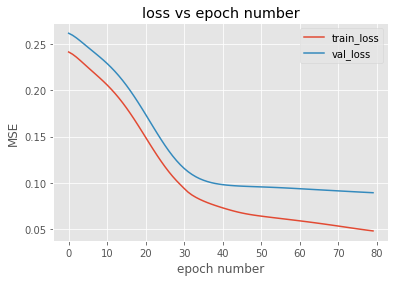

319

(25839, 28)

(25839, 1)

FIT: tyle jest frauds:

(319, 29)

FIT: tyle jest normals:

(25520, 29)

Loss: 

0.284061235292

 Accuracy: 

0.5329153605015674

Loss: 

0.273208829419

 Accuracy: 

0.5454545454545454

Loss: 

0.257949440118

 Accuracy: 

0.5642633228840125

Loss: 

0.239249247911

 Accuracy: 

0.5830721003134797

Loss: 

0.217966859933

 Accuracy: 

0.6081504702194357

Loss: 

0.198609298935

 Accuracy: 

0.6363636363636364

Loss: 

0.186617327377

 Accuracy: 

0.6536050156739812

Loss: 

0.182163385031

 Accuracy: 

0.6551724137931034

Loss: 

0.181432112549

 Accuracy: 

0.6489028213166145

Loss: 

0.181092296691

 Accuracy: 

0.6489028213166145

Loss: 

0.181341187701

 Accuracy: 

0.64576802507837

Loss: 

0.181977449501

 Accuracy: 

0.6473354231974922

Loss: 

0.182292947302

 Accuracy: 

0.6504702194357367

Loss: 

0.182156568287

 Accuracy: 

0.6504702194357367

Loss: 

0.181538560142

 Accuracy: 

0.6520376175548589

Loss: 

0.180425257404

 Accuracy: 

0.6551724137931034

Loss: 

0.178808064488

 Accuracy: 

0.658307210031348

Loss: 

0.176685231835

 Accuracy: 

0.6630094043887147

Loss: 

0.174065402964

 Accuracy: 

0.6724137931034483

Loss: 

0.170962756304

 Accuracy: 

0.6818181818181818

Loss: 

0.167401666754

 Accuracy: 

0.6880877742946708

Loss: 

0.163411612803

 Accuracy: 

0.6990595611285266

Loss: 

0.159028581628

 Accuracy: 

0.7178683385579937

Loss: 

0.154303060932

 Accuracy: 

0.7335423197492164

Loss: 

0.149295856657

 Accuracy: 

0.7476489028213166

Loss: 

0.144075878369

 Accuracy: 

0.7617554858934169

Loss: 

0.138706137635

 Accuracy: 

0.7852664576802508

Loss: 

0.133257350485

 Accuracy: 

0.7946708463949843

Loss: 

0.127803579175

 Accuracy: 

0.8087774294670846

Loss: 

0.122408702887

 Accuracy: 

0.8244514106583072

Loss: 

0.117132907374

 Accuracy: 

0.841692789968652

Loss: 

0.112029988449

 Accuracy: 

0.8605015673981191

Loss: 

0.107142982661

 Accuracy: 

0.8714733542319749

Loss: 

0.102509937871

 Accuracy: 

0.8808777429467085

Loss: 

0.0981659389611

 Accuracy: 

0.8824451410658307

Loss: 

0.0941400033198

 Accuracy: 

0.8887147335423198

Loss: 

0.0904552280904

 Accuracy: 

0.8934169278996865

Loss: 

0.0871284406357

 Accuracy: 

0.8887147335423198

Loss: 

0.0841675320316

 Accuracy: 

0.8949843260188087

Loss: 

0.0815701296192

 Accuracy: 

0.8981191222570533

Loss: 

0.0793259809017

 Accuracy: 

0.9012539184952978

Loss: 

0.077416625276

 Accuracy: 

0.9059561128526645

Loss: 

0.0758191613929

 Accuracy: 

0.9090909090909091

Loss: 

0.0745073541976

 Accuracy: 

0.9106583072100314

Loss: 

0.073452965834

 Accuracy: 

0.9137931034482759

Loss: 

0.0726273219239

 Accuracy: 

0.9153605015673981

Loss: 

0.0720024982384

 Accuracy: 

0.9169278996865203

Loss: 

0.0715523532773

 Accuracy: 

0.9122257053291536

Loss: 

0.071252448466

 Accuracy: 

0.9122257053291536

Loss: 

0.0710807741306

 Accuracy: 

0.9122257053291536

Loss: 

0.0710175390772

 Accuracy: 

0.9122257053291536

Loss: 

0.0710448820147

 Accuracy: 

0.9122257053291536

Loss: 

0.0711469829057

 Accuracy: 

0.9122257053291536

Loss: 

0.0713090458522

 Accuracy: 

0.9122257053291536

Loss: 

0.0715183558836

 Accuracy: 

0.9122257053291536

Loss: 

0.0717642132812

 Accuracy: 

0.9122257053291536

Loss: 

0.0720369255591

 Accuracy: 

0.9106583072100314

Loss: 

0.072328148473

 Accuracy: 

0.9106583072100314

Loss: 

0.0726307115489

 Accuracy: 

0.9122257053291536

Loss: 

0.0729383505755

 Accuracy: 

0.9090909090909091

Loss: 

0.0732454314795

 Accuracy: 

0.9090909090909091

Loss: 

0.0735473826257

 Accuracy: 

0.9090909090909091

Loss: 

0.073840367512

 Accuracy: 

0.9075235109717869

Loss: 

0.0741206313009

 Accuracy: 

0.9075235109717869

Loss: 

0.0743858546334

 Accuracy: 

0.9075235109717869

Loss: 

0.0746337256163

 Accuracy: 

0.9075235109717869

Loss: 

0.0748629277456

 Accuracy: 

0.9075235109717869

Loss: 

0.0750722592286

 Accuracy: 

0.9075235109717869

Loss: 

0.0752606992587

 Accuracy: 

0.9075235109717869

Loss: 

0.0754279198603

 Accuracy: 

0.9075235109717869

Loss: 

0.0755734307926

 Accuracy: 

0.9090909090909091

Loss: 

0.0756969583434

 Accuracy: 

0.9090909090909091

Loss: 

0.0757984012592

 Accuracy: 

0.9090909090909091

Loss: 

0.0758777793307

 Accuracy: 

0.9090909090909091

Loss: 

0.0759351875762

 Accuracy: 

0.9090909090909091

Loss: 

0.0759709157871

 Accuracy: 

0.9090909090909091

Loss: 

0.0759847514573

 Accuracy: 

0.9090909090909091

Loss: 

0.0759771580278

 Accuracy: 

0.9090909090909091

Loss: 

0.0759485423454

 Accuracy: 

0.9090909090909091

Loss: 

0.0758993808855

 Accuracy: 

0.9106583072100314


Validation dataset evaluation:

Loss: 

0.0677613616323

Accuracy: 

0.9125

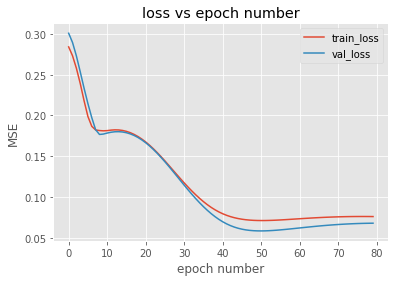

320

(25920, 28)

(25920, 1)

FIT: tyle jest frauds:

(320, 29)

FIT: tyle jest normals:

(25600, 29)

Loss: 

0.241650366221

 Accuracy: 

0.5765625

Loss: 

0.240397570759

 Accuracy: 

0.578125

Loss: 

0.2385387305

 Accuracy: 

0.578125

Loss: 

0.235971987032

 Accuracy: 

0.5796875

Loss: 

0.232818286161

 Accuracy: 

0.5828125

Loss: 

0.229084694343

 Accuracy: 

0.5859375

Loss: 

0.224758988073

 Accuracy: 

0.59375

Loss: 

0.219918078188

 Accuracy: 

0.5984375

Loss: 

0.214521470785

 Accuracy: 

0.603125

Loss: 

0.208477403771

 Accuracy: 

0.6078125

Loss: 

0.201907845879

 Accuracy: 

0.6171875

Loss: 

0.194807634806

 Accuracy: 

0.6328125

Loss: 

0.187357068791

 Accuracy: 

0.64375

Loss: 

0.179567713789

 Accuracy: 

0.653125

Loss: 

0.171588325697

 Accuracy: 

0.665625

Loss: 

0.163445158357

 Accuracy: 

0.6859375

Loss: 

0.155367490257

 Accuracy: 

0.715625

Loss: 

0.147398171039

 Accuracy: 

0.7421875

Loss: 

0.139880342768

 Accuracy: 

0.759375

Loss: 

0.132965069361

 Accuracy: 

0.7890625

Loss: 

0.126686432546

 Accuracy: 

0.8046875

Loss: 

0.121408953798

 Accuracy: 

0.8265625

Loss: 

0.117272430116

 Accuracy: 

0.8421875

Loss: 

0.114401298782

 Accuracy: 

0.85625

Loss: 

0.112985674255

 Accuracy: 

0.86875

Loss: 

0.11335543824

 Accuracy: 

0.8734375

Loss: 

0.115813091331

 Accuracy: 

0.875

Loss: 

0.119530745706

 Accuracy: 

0.865625

Loss: 

0.124468538045

 Accuracy: 

0.865625

Loss: 

0.130797706936

 Accuracy: 

0.85

Loss: 

0.137207774148

 Accuracy: 

0.8421875

Loss: 

0.141210454706

 Accuracy: 

0.8375

Loss: 

0.141498610835

 Accuracy: 

0.8359375

Loss: 

0.138017194197

 Accuracy: 

0.8375

Loss: 

0.131965462338

 Accuracy: 

0.8453125

Loss: 

0.124797148795

 Accuracy: 

0.853125

Loss: 

0.117734061139

 Accuracy: 

0.8578125

Loss: 

0.111216221791

 Accuracy: 

0.865625

Loss: 

0.10528109463

 Accuracy: 

0.871875

Loss: 

0.099688020564

 Accuracy: 

0.875

Loss: 

0.0942761185976

 Accuracy: 

0.8875

Loss: 

0.0892371524283

 Accuracy: 

0.890625

Loss: 

0.0853753564141

 Accuracy: 

0.89375

Loss: 

0.0824582233855

 Accuracy: 

0.896875

Loss: 

0.0800030900138

 Accuracy: 

0.896875

Loss: 

0.0778433904717

 Accuracy: 

0.8984375

Loss: 

0.0759266436316

 Accuracy: 

0.9046875

Loss: 

0.0742156670241

 Accuracy: 

0.9046875

Loss: 

0.0726807193394

 Accuracy: 

0.9078125

Loss: 

0.0712820840319

 Accuracy: 

0.909375

Loss: 

0.069986038096

 Accuracy: 

0.909375

Loss: 

0.0687807110872

 Accuracy: 

0.9109375

Loss: 

0.0676505507068

 Accuracy: 

0.9140625

Loss: 

0.0665882291678

 Accuracy: 

0.915625

Loss: 

0.0655884097129

 Accuracy: 

0.9203125

Loss: 

0.0646329195967

 Accuracy: 

0.9234375

Loss: 

0.0637231759949

 Accuracy: 

0.921875

Loss: 

0.0628496114175

 Accuracy: 

0.921875

Loss: 

0.062019622767

 Accuracy: 

0.925

Loss: 

0.0612284413001

 Accuracy: 

0.925

Loss: 

0.0604814593005

 Accuracy: 

0.925

Loss: 

0.0597762167577

 Accuracy: 

0.9265625

Loss: 

0.0591159635828

 Accuracy: 

0.9296875

Loss: 

0.0584946825336

 Accuracy: 

0.93125

Loss: 

0.0579173774137

 Accuracy: 

0.93125

Loss: 

0.0573912071633

 Accuracy: 

0.9296875

Loss: 

0.0569066750298

 Accuracy: 

0.93125

Loss: 

0.0564686267299

 Accuracy: 

0.93125

Loss: 

0.0560687888263

 Accuracy: 

0.93125

Loss: 

0.0557076166206

 Accuracy: 

0.93125

Loss: 

0.0553828887431

 Accuracy: 

0.9296875

Loss: 

0.0550886344467

 Accuracy: 

0.9296875

Loss: 

0.0548220037879

 Accuracy: 

0.9296875

Loss: 

0.054582931543

 Accuracy: 

0.93125

Loss: 

0.0543661994264

 Accuracy: 

0.9296875

Loss: 

0.0541691327099

 Accuracy: 

0.928125

Loss: 

0.0539893607369

 Accuracy: 

0.928125

Loss: 

0.0538236824143

 Accuracy: 

0.928125

Loss: 

0.0536702739198

 Accuracy: 

0.928125

Loss: 

0.0535258228158

 Accuracy: 

0.928125


Validation dataset evaluation:

Loss: 

0.049052347193

Accuracy: 

0.9430379746835443

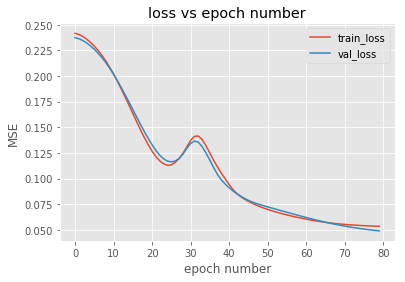

In [36]:
for k, validation_frauds in enumerate(kfold_split_frauds):
    #print(k_fold_split_array)
    #losowanie dobrych transakcji
    
    """normal_indices_split_array = k_fold_split_data(random_normal_indices, 5)
    validation_normal_indices = normal_indices_split_array.pop(n)
    normal_indices_split_array = np.concatenate(normal_indices_split_array)"""

    #Get train frauds from train&validation frauds
    train_frauds = kfold_split_frauds.copy()
    train_frauds.pop(k)
    """print(len(train_frauds))"""
    train_frauds = np.concatenate(train_frauds)
    print(len(train_frauds))
    
    """validation_normals = random_normal_indices[rand_validation_normal_ind_split[k]]"""
    validation_normals = kfold_split_normals[k]
    """train_normals = np.delete(arr = random_normal_indices, obj = rand_validation_normal_ind_split[k], axis = 0)"""
    train_normals = get_radnom_normal_indices(dataset, train_and_validation, amount=train_frauds.shape[0]*80)
    train_normals = train_normals.values
    
    """
    #print("len of random normal indices:", len(random_normal_indices))
    normal_segment_to_delete = rand_validation_n_i[k]
    #print(normal_segment_to_delete)
    normal_indices_to_delete = np.arange(start = normal_segment_to_delete*SEGMENT_SIZE, stop = (normal_segment_to_delete+1)*SEGMENT_SIZE)
    print(len(normal_indices_to_delete))
    train_normals = np.delete(arr = random_normal_indices, obj = normal_indices_to_delete, axis = 0)
    validation_normals = random_normal_indices[normal_indices_to_delete]
    
    print(len(validation_frauds), len(validation_normals))
    """
    #print(train_normals, "2", train_normals2)
    #print("len of ranfom normal indices deleted:", len(train_normals))
    #print("len of random normal indices before delete - segment size:", len(random_normal_indices)-SEGMENT_SIZE)
    train = np.concatenate([train_frauds, train_normals])
    
    #train = np.concatenate([train,normal_indices_split_array])
    
    x_train = train[:, :-1]
    y_train = train[:, -1:]
    

    validation = np.concatenate([validation_frauds,validation_normals])
    np.random.shuffle(validation)

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

        # 653
    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation, distinct=1)

    print("\n", '='*80)
    print("\nValidation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    plot_loss(model.epochs, model.training_history, model.validation_history)
    models.append(model)


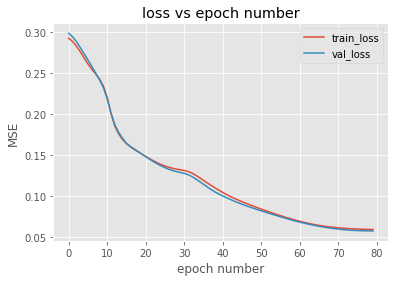

In [37]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [38]:
print("\nTest dataset evaluation:")
x_train_and_validation = under_sample_dataset[:, :-1]
y_train_and_validation = under_sample_dataset[:, -1:]

test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation)



Test dataset evaluation:

(798, 28)

(798, 1)

FIT: tyle jest frauds:

(399, 29)

FIT: tyle jest normals:

(399, 29)

Loss: 

0.498281252927

 Accuracy: 

0.24812030075187969

Loss: 

0.491476053316

 Accuracy: 

0.24812030075187969

Loss: 

0.479694153625

 Accuracy: 

0.2531328320802005

Loss: 

0.460172949811

 Accuracy: 

0.2568922305764411

Loss: 

0.427634119738

 Accuracy: 

0.2756892230576441

Loss: 

0.375714312937

 Accuracy: 

0.32706766917293234

Loss: 

0.307093296094

 Accuracy: 

0.42606516290726815

Loss: 

0.251794035701

 Accuracy: 

0.5162907268170426

Loss: 

0.227897371427

 Accuracy: 

0.5476190476190477

Loss: 

0.217795908457

 Accuracy: 

0.5601503759398496

Loss: 

0.21830851194

 Accuracy: 

0.5488721804511278

Loss: 

0.221027064715

 Accuracy: 

0.5463659147869674

Loss: 

0.223895916821

 Accuracy: 

0.5476190476190477

Loss: 

0.226489345165

 Accuracy: 

0.5451127819548872

Loss: 

0.228628069491

 Accuracy: 

0.5451127819548872

Loss: 

0.230228532092

 Accuracy: 

0.5426065162907269

Loss: 

0.231252098966

 Accuracy: 

0.543859649122807

Loss: 

0.231680869754

 Accuracy: 

0.5451127819548872

Loss: 

0.231505495187

 Accuracy: 

0.5488721804511278

Loss: 

0.230720045185

 Accuracy: 

0.556390977443609

Loss: 

0.229320437224

 Accuracy: 

0.556390977443609

Loss: 

0.227304419849

 Accuracy: 

0.5651629072681704

Loss: 

0.224672004685

 Accuracy: 

0.5714285714285714

Loss: 

0.221426074672

 Accuracy: 

0.5776942355889725

Loss: 

0.217573016419

 Accuracy: 

0.5902255639097744

Loss: 

0.213123388952

 Accuracy: 

0.5977443609022557

Loss: 

0.208092671768

 Accuracy: 

0.6127819548872181

Loss: 

0.202502052223

 Accuracy: 

0.6278195488721805

Loss: 

0.196379260531

 Accuracy: 

0.6428571428571429

Loss: 

0.189759329865

 Accuracy: 

0.6591478696741855

Loss: 

0.182685414247

 Accuracy: 

0.6704260651629073

Loss: 

0.175209536828

 Accuracy: 

0.6917293233082706

Loss: 

0.167393465626

 Accuracy: 

0.7180451127819549

Loss: 

0.159309976584

 Accuracy: 

0.7481203007518797

Loss: 

0.151044711182

 Accuracy: 

0.7719298245614035

Loss: 

0.142698040277

 Accuracy: 

0.7894736842105263

Loss: 

0.134384159771

 Accuracy: 

0.8145363408521303

Loss: 

0.126222105381

 Accuracy: 

0.8295739348370927

Loss: 

0.118318427293

 Accuracy: 

0.8483709273182958

Loss: 

0.110753462643

 Accuracy: 

0.8646616541353384

Loss: 

0.103582330717

 Accuracy: 

0.8796992481203008

Loss: 

0.0968444913792

 Accuracy: 

0.8884711779448622

Loss: 

0.090569934623

 Accuracy: 

0.893483709273183

Loss: 

0.0847801752804

 Accuracy: 

0.899749373433584

Loss: 

0.0794880237936

 Accuracy: 

0.9022556390977443

Loss: 

0.0746985991013

 Accuracy: 

0.9072681704260651

Loss: 

0.0704110395593

 Accuracy: 

0.9085213032581454

Loss: 

0.0666196936262

 Accuracy: 

0.9147869674185464

Loss: 

0.063314322704

 Accuracy: 

0.9197994987468672

Loss: 

0.0604799607797

 Accuracy: 

0.9235588972431078

Loss: 

0.0580987298382

 Accuracy: 

0.9260651629072681

Loss: 

0.0561546701636

 Accuracy: 

0.924812030075188

Loss: 

0.0546372198116

 Accuracy: 

0.9285714285714286

Loss: 

0.0535343662388

 Accuracy: 

0.9285714285714286

Loss: 

0.0528163672166

 Accuracy: 

0.9298245614035088

Loss: 

0.0524289061453

 Accuracy: 

0.9298245614035088

Loss: 

0.0523053730222

 Accuracy: 

0.9298245614035088

Loss: 

0.0523836298943

 Accuracy: 

0.9323308270676691

Loss: 

0.0526136277486

 Accuracy: 

0.9335839598997494

Loss: 

0.0529571643192

 Accuracy: 

0.9348370927318296

Loss: 

0.0533852327622

 Accuracy: 

0.9335839598997494

Loss: 

0.0538756909391

 Accuracy: 

0.931077694235589

Loss: 

0.0544116516256

 Accuracy: 

0.9298245614035088

Loss: 

0.0549803026926

 Accuracy: 

0.9273182957393483

Loss: 

0.055571921858

 Accuracy: 

0.9273182957393483

Loss: 

0.0561790182036

 Accuracy: 

0.9273182957393483

Loss: 

0.056795561918

 Accuracy: 

0.9273182957393483

Loss: 

0.0574163437434

 Accuracy: 

0.9273182957393483

Loss: 

0.0580365747005

 Accuracy: 

0.924812030075188

Loss: 

0.0586516159199

 Accuracy: 

0.924812030075188

Loss: 

0.0592569512102

 Accuracy: 

0.9235588972431078

Loss: 

0.0598482947304

 Accuracy: 

0.9235588972431078

Loss: 

0.0604217345233

 Accuracy: 

0.9223057644110275

Loss: 

0.0609740534336

 Accuracy: 

0.9235588972431078

Loss: 

0.0615026584534

 Accuracy: 

0.9235588972431078

Loss: 

0.0620056852662

 Accuracy: 

0.924812030075188

Loss: 

0.0624819584671

 Accuracy: 

0.9235588972431078

Loss: 

0.0629309179565

 Accuracy: 

0.9235588972431078

Loss: 

0.0633525232847

 Accuracy: 

0.9235588972431078

Loss: 

0.0637471501687

 Accuracy: 

0.9235588972431078

In [39]:
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

Loss: 

0.00809994988082

Accuracy: 

0.9913802183912082

  0%|                                                   | 0/21 [00:00<?, ?it/s]

  5%|██                                         | 1/21 [00:06<02:04,  6.24s/it]

 10%|████                                       | 2/21 [00:10<01:37,  5.15s/it]

 14%|██████▏                                    | 3/21 [00:16<01:40,  5.58s/it]

 19%|████████▏                                  | 4/21 [00:21<01:31,  5.40s/it]

 24%|██████████▏                                | 5/21 [00:26<01:23,  5.21s/it]

 29%|████████████▎                              | 6/21 [00:30<01:15,  5.05s/it]

 33%|██████████████▎                            | 7/21 [00:36<01:13,  5.26s/it]

 38%|████████████████▍                          | 8/21 [00:41<01:07,  5.22s/it]

 43%|██████████████████▍                        | 9/21 [00:47<01:03,  5.25s/it]

 48%|████████████████████                      | 10/21 [00:53<00:58,  5.32s/it]

 52%|██████████████████████                    | 11/21 [00:57<00:52,  5.27s/it]

 57%|████████████████████████                  | 12/21 [01:02<00:46,  5.17s/it]

 62%|██████████████████████████                | 13/21 [01:06<00:40,  5.09s/it]

 67%|████████████████████████████              | 14/21 [01:10<00:35,  5.03s/it]

 71%|██████████████████████████████            | 15/21 [01:14<00:29,  4.98s/it]

 76%|████████████████████████████████          | 16/21 [01:18<00:24,  4.93s/it]

 81%|██████████████████████████████████        | 17/21 [01:23<00:19,  4.89s/it]

 86%|████████████████████████████████████      | 18/21 [01:27<00:14,  4.86s/it]

 90%|██████████████████████████████████████    | 19/21 [01:31<00:09,  4.82s/it]

 95%|████████████████████████████████████████  | 20/21 [01:37<00:04,  4.89s/it]

100%|██████████████████████████████████████████| 21/21 [01:43<00:00,  4.91s/it]

No handles with labels found to put in legend.

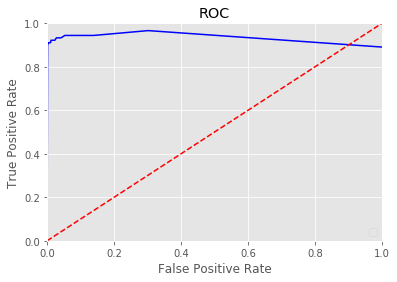

In [ ]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)
